# Fake News Detection Using Natural Language Processing (NLP) and Classification Modeling

### Abstract
How might Natural Language Processing better inform us about how fake news filters get created? This case study attempts to distinguish between _fake news_ and _absurd news_ by building a classification model trained on Subreddit posts from r/TheOnion and r/nottheonion. I believe it's imperative to maintain a high level of accuracy when creating a fake news detector--where all fake news gets filtered out and authentic news will not be affected by a filter. 

**What is The Onion and Not The Onion?**

(1)**The Onion** is an absurd satirical publication, written in such a way that people often mistake it for being real.

https://www.reddit.com/r/TheOnion/

**Not the Onion** is a subreddit that lists real news stories so absurd that you could honestly believe they were fake.

https://www.reddit.com/r/nottheonion/

(2)**The Onion** runs **fake news** stories that should be real, wheres **Not The Onion** runs **real news** stories that should be fake.

(3)**The Onion** is a **fake news** site which makes humorous news.
**r/nottheonion** is for news so absurd you automatically think that they're from The Onion.


### Contents
- [**Import Libraries**](#Import-Libraries)
- [**Data Scrape**](#Data-Scrape)
 - [API Scrape Function](#API-Scrape-Function)
 - [Scrape r/notheonion](#Scrape-r/nottheonion)
 - [Scrape r/TheOnion](#Scrape-r/TheOnion)
- [**Import Data**](#Import-Data)
 - [Preview `df_onion`](#Preview-df_onion)
- [**Clean Data**](#Clean-Data)
 - [Data Cleaning Function](#Data-Cleaning-Function)
 - [Clean `df_onion`](#Clean-df_onion)
 - [Clean `df_not_onion`](#Clean-df_not_onion)
 - [Check Nulls](#Check-Nulls)
- [**Exploratory Data Analysis (EDA)**](#Exploratory-Data-Analysis-(EDA))
 - [Data Range of Scraped Posts](#Data-Range-of-Scraped-Posts)
 - [Bar Plot Function](#Bar-Plot-Function)
 - [r/TheOnion: Most Active Authors](#r/TheOnion:-Most-Active-Authors)
 - [r/nottheonion: Most Active Authors](#r/nottheonion:-Most-Active-Authors)
 - [r/TheOnion: Most Referenced Domains](#r/TheOnion:-Most-Referenced-Domains)
 - [r/nottheonion: Most Referenced Domains](#r/nottheonion:-Most-Referenced-Domains)
- [**Natural Language Processing (NLP)**](#Natural-Language-Processing-(NLP))
 - [Concatenate DataFrames](#Concatenate-DataFrames)
 - [Binarize Target `subreddit`](#Binarize-Target-subreddit)
 - [Apply `CountVectorizer()`](#Apply-CountVectorizer())
 - [r/TheOnion: Top 5 Unigrams](#r/TheOnion:-Top-5-Unigrams)
 - [r/nottheonion: Top 5 Unigrams](#r/nottheonion:-Top-5-Unigrams)
 - [r/nottheonion: Top 5 Bigrams](#r/nottheonion:-Top-5-Bigrams)
 - [r/nottheonion: Top 5 Bigrams](#r/nottheonion:-Top-5-Bigrams)
 - [Create custom `stop_words` to include common frequent words](#Create-custom-stop_words-to-include-common-frequent-words)
- [**Modeling**](#Modeling)
 - [Baseline Score](#Baseline-Score)
 - [Set `X` (predictor) and `y` (target) variables](#Set-X-(predictor)-and-y-(target)-variables)
 - [Train/Test Split](#Train/Test-Split)
 - [Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)](#Model-1:-CountVectorizer-&-Logistic-Regression-(Best-Coefficient-Interpretability))
 - [Model 2: TfidfVectorize & Logistic Regression](#Model-2:-TfidfVectorize-&-Logistic-Regression)
 - [Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)](#Model-3:-CountVectorizer-&-MultinomialNB-(Best-Accuracy-Score))
 - [Model 4: TfidfVectorizer & MultinomialNB](#Model-4:-TfidfVectorizer-&-MultinomialNB)
- [**Best Models**](#Best-Models)
 - [CountVectorizer & MultinomialNB: Best Score](#CountVectorizer-&-MultinomialNB:-Best-Score)
 - [Confusion Matrix](#Confusion-Matrix)
 - [CountVectorizer & Logistic Regression: Best Coefficient Interpretability](#CountVectorizer-&-Logistic-Regression:-Best-Coefficient-Interpretability)
 - [Coefficient Analysis](#Coefficient-Analysis)
- [**Conclusions and Next-Steps**](#Conclusions-and-Next-Steps)

# Import Libraries

In [1]:
#pip install psaw

https://psaw.readthedocs.io/en/latest/

In [2]:
# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Scrape

I chose to scrape posts from r/TheOnion and r/nottheonion in order to create a fake news model that could accurately distinguish between fake news and absurd news. From each subbreddit I scraped the following information:  
 - `title`: title of subreddit post 
 - `subreddit`: which subreddit the post belongs to 
 - `num_comments`: the number of comments for a post 
 - `author`: author's username of a post
 - `subreddit_subcribers`: number of subcribers for that subreddit 
 - `score`: the score received on reddit 
 - `domain`: the domain referenced in the post 
 - `created_utc`: date and time the post was created





### API Scrape Function

In [3]:
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=10000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

### Scrape r/nottheonion

In [4]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')

# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 522
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 525
  warnings.warn("Got non 200 code %s" % response.status_code)


nottheonion subscribers: 19141918
df_not_onion shape: (10000, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,polopiko,sickchirpse.com,Private School Teacher Banned After Taking Stu...,1,1,1619367026
1,nottheonion,Jonadrews,theguardian.com,Why parents are choosing to rent their kids’ c...,0,1,1619366855
2,nottheonion,jorga-k,squeekly.com,Russia considers ban on Czech beer amid recent...,0,1,1619365637
3,nottheonion,alwaysshitting,hindustantimes.com,"Govt orders removal of posts on Covid-19, term...",0,1,1619365612
4,nottheonion,duzzy50,huffpost.com,Not plant based beer!,1,1,1619365131


### Scrape r/TheOnion

In [5]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 525
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


theonion subscribers: 160719
df_onion shape: (9978, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,IOFIFO,youtu.be,"We Couldn't Get The Rights To ""Purple Rain,"" S...",1,1,1619300296
1,TheOnion,aresef,local.theonion.com,"‘Top You Off?’ Asks Diner Waitress, Tipping Ca...",25,1,1619281718
2,TheOnion,BeefBaeby,dailyhive.com,911 is Already Getting Calls from People Askin...,2,1,1619240192
3,TheOnion,Sanlear,theonion.com,Tim Cook Unveils Air Fryer He Got For Christmas,0,1,1619204676
4,TheOnion,mothershipq,theonion.com,Nation’s Bald Citizens Band Together To Demand...,1,1,1619204304


In total, **19,978** posts were scraped: **10k** from r/nottheonion and **9,978** from r/TheOnion. 

# Import Data

In [6]:
# If you're running this notebook, you can begin with this cell as the data has already been saved to a csv

# r/TheOnion DataFrame
#df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
#df_not_onion = pd.read_csv('./data/not_onion.csv')

### Preview `df_onion`

In [7]:
# Show first 5 rows of df_onion
#print("Shape:", df_onion.shape)
#df_onion.head()

### Preview `df_not_onion`

In [8]:
# Show first 5 rows of df_not_onion
#print("Shape:", df_not_onion.shape)
#df_not_onion.head()

# Clean Data

### Data Cleaning Function

In [9]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

### Clean `df_onion`

In [10]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (9043, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,IOFIFO,youtu.be,we couldn t get the rights to purple rain so w...,1,1,1619300296
1,TheOnion,aresef,local.theonion.com,top you off asks diner waitress tipping caraf...,25,1,1619281718
2,TheOnion,BeefBaeby,dailyhive.com,is already getting calls from people asking a...,2,1,1619240192
3,TheOnion,Sanlear,theonion.com,tim cook unveils air fryer he got for christmas,0,1,1619204676
4,TheOnion,mothershipq,theonion.com,nation s bald citizens band together to demand...,1,1,1619204304


2935 rows from df_union are dropped because of duplication.

In [11]:
df_onion["title"].isnull().sum() # title is our target column. I check whether there are missing values for title.

0

### Clean `df_not_onion`

In [12]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (7977, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,polopiko,sickchirpse.com,private school teacher banned after taking stu...,1,1,1619367026
1,nottheonion,Jonadrews,theguardian.com,why parents are choosing to rent their kids cl...,0,1,1619366855
2,nottheonion,jorga-k,squeekly.com,russia considers ban on czech beer amid recent...,0,1,1619365637
3,nottheonion,alwaysshitting,hindustantimes.com,govt orders removal of posts on covid terms i...,0,1,1619365612
4,nottheonion,duzzy50,huffpost.com,not plant based beer,1,1,1619365131


4016 rows from df_not_onion are dropped.

### Check Nulls

In [13]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
subreddit,0,0
author,0,0
domain,0,0
title,0,0
num_comments,0,0
score,0,0
timestamp,0,0


# Exploratory Data Analysis (EDA)

### Date Range of Scraped Posts

In [14]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2018-04-13 20:51:11
TheOnion end date: 2021-04-24 21:38:16
nottheonion start date: 2021-02-10 18:49:10
nottheonion end date: 2021-04-25 16:10:26


### Bar Plot Function

In [15]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

### r/TheOnion: Most Active Authors

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


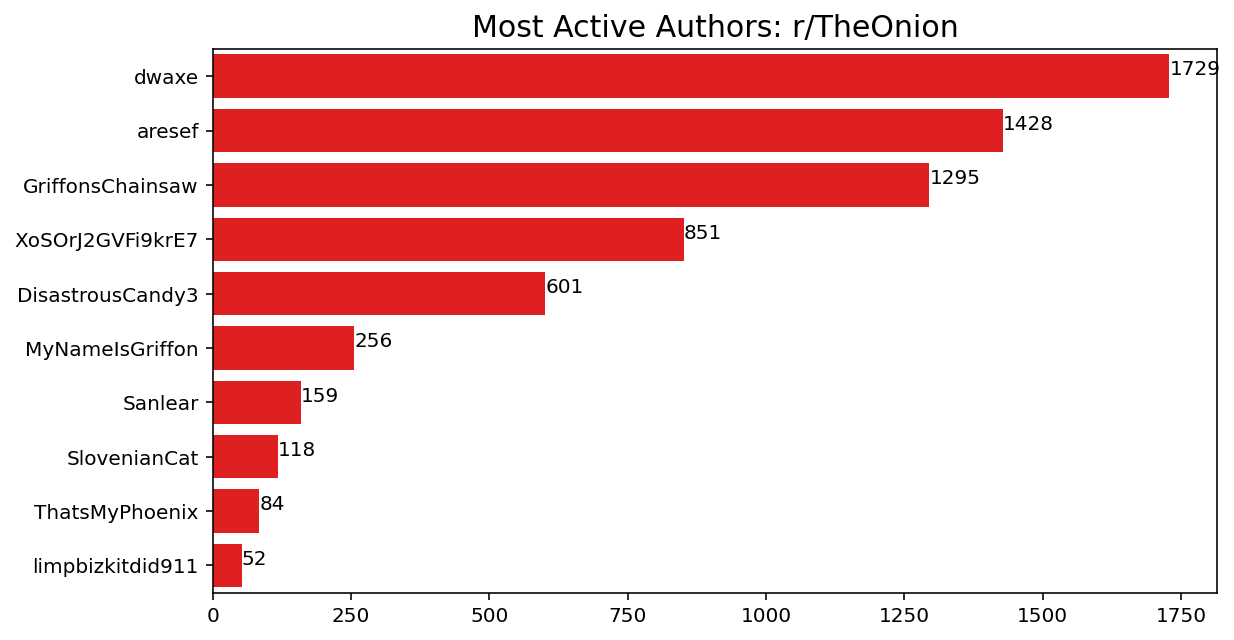

In [16]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 50].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r') 

r/TheOnion has only 160k subscribers, but 10 authors shared over 50 posts, the most being 1,712 posts.

### r/nottheonion: Most Active Authors

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


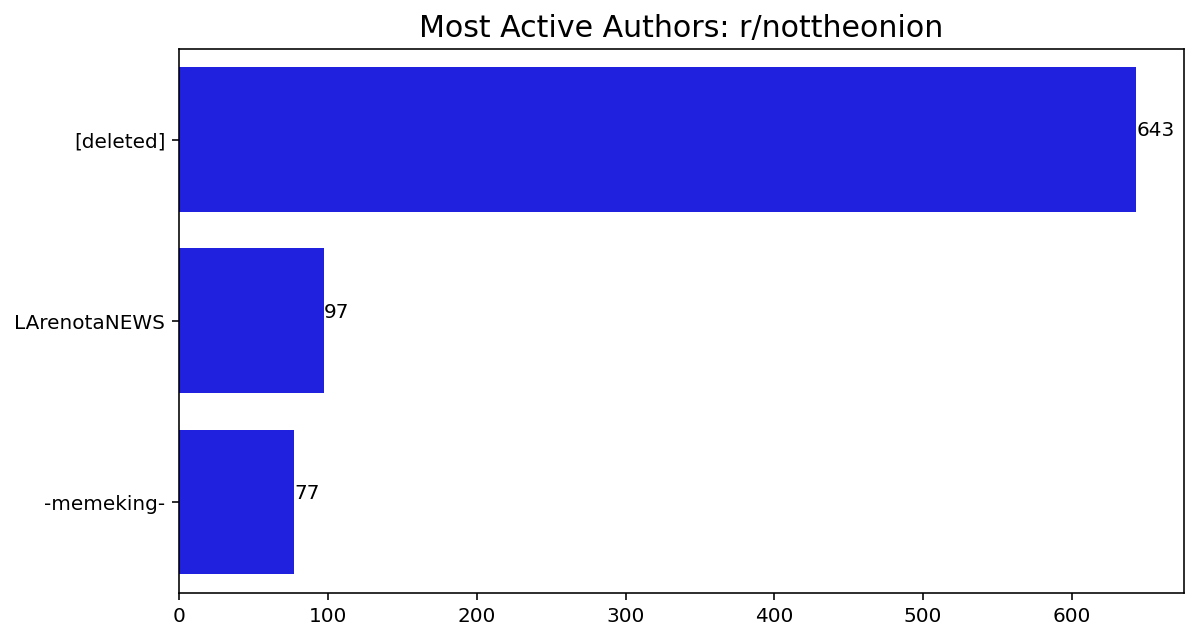

In [17]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 50].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b') 

r/nottheonion has 19.1 m subscribers, and only 3 authors shared over 50 posts.   

### r/TheOnion: Most Referenced Domains

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


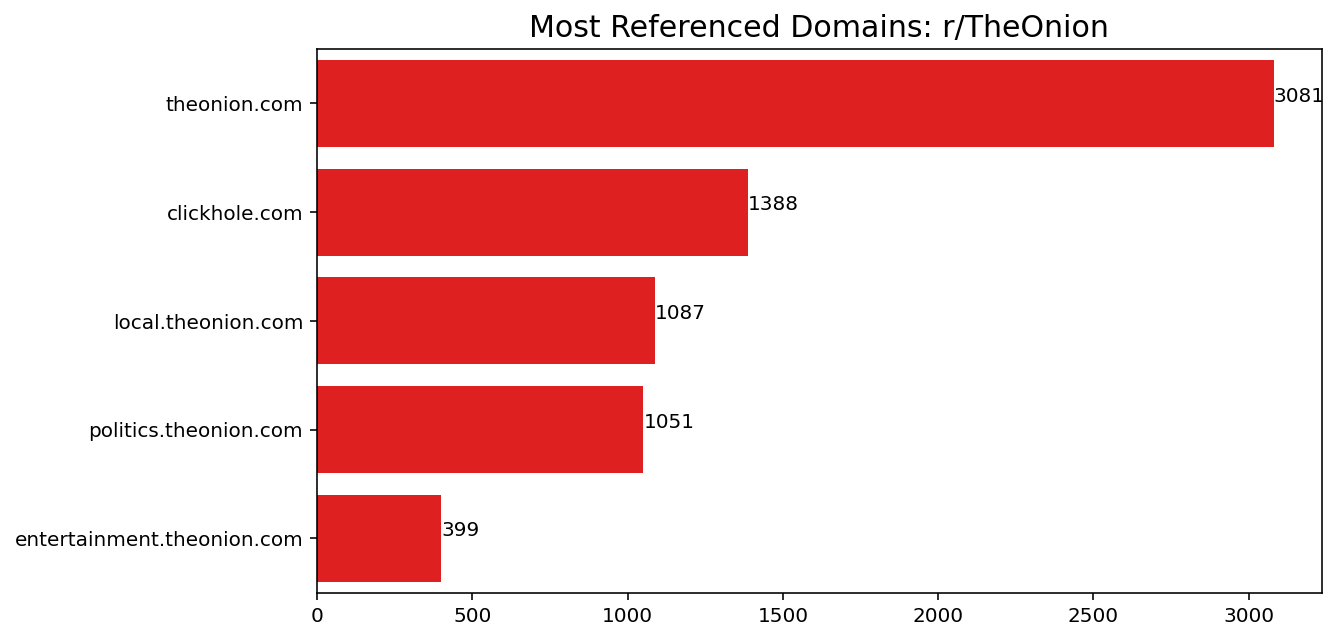

In [18]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r') 

Unsurprisingly, the most referenced domains from r/TheOnion are from The Onion. This subreddit allows articles from other news satire sites to be shared here as well.

### r/nottheonion: Most Referenced Domains

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


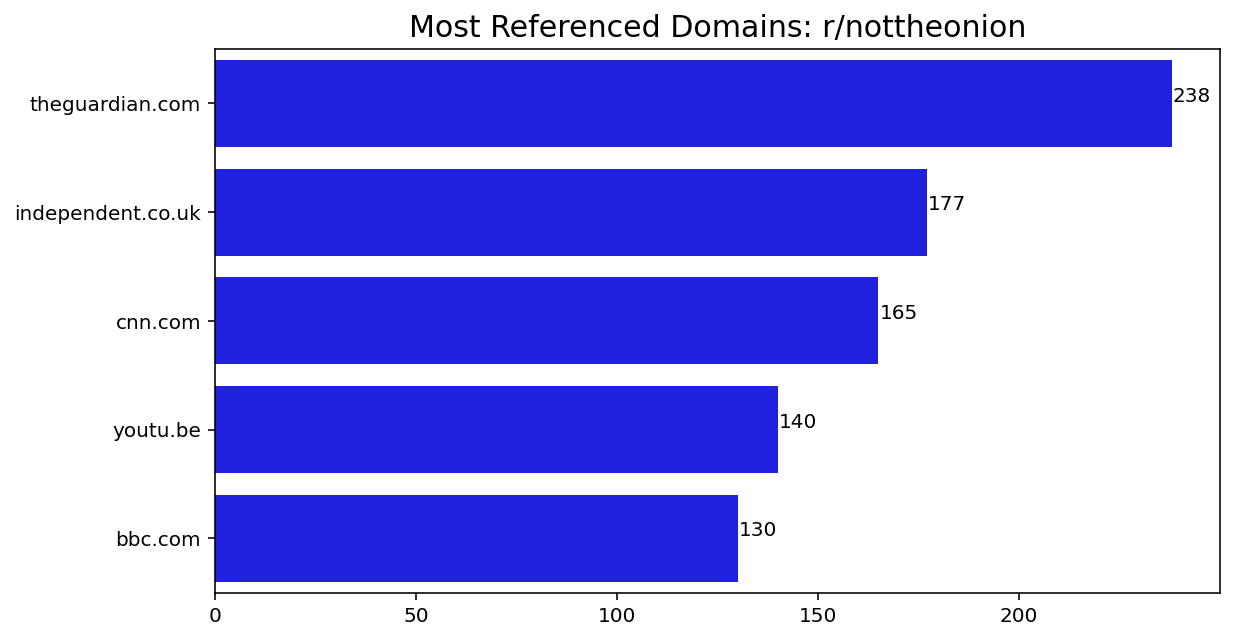

In [19]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b') 

Also unsurprisingly, theguardian.com is the most referenced domain in r/nottheonion! 

# Natural Language Processing (NLP)

Here I use Count Vectorizer to continue my EDA and explore the most used words and combinations of words from each subreddit. 

### Concatenate DataFrames

In [20]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,we couldn t get the rights to purple rain so w...
1,TheOnion,top you off asks diner waitress tipping caraf...


In [21]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
17018,nottheonion,conservationists plead with public to stop mil...
17019,nottheonion,no defends taxpayer funded photos of pm s dog ...


### Binarize Target `subreddit`
 - `TheOnion`: 1
 - `nottheonion`: 0

In [22]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(17020, 2)


,subreddit,title
0,1,we couldn t get the rights to purple rain so w...
1,1,top you off asks diner waitress tipping caraf...


In [23]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
17018,0,conservationists plead with public to stop mil...
17019,0,no defends taxpayer funded photos of pm s dog ...


In [24]:
df.sample(20)


,subreddit,title
13198,0,announcer at girls high school basketball game...
2848,1,new iphone has built in full size polaroid cam...
10315,0,bezos says amazon workers aren t treated like ...
15383,0,coca cola wants employees to be less white
2041,1,don t tell me you ve never wondered what yoda ...
13147,0,announcer cites low blood sugar for making rac...
12642,0,uber says it will treat uk drivers as workers ...
4040,1,christian bale loses years for upcoming movie ...
4663,1,man competitive about how depressed he is
510,1,your honor i m ready to present says giuliani...


## Apply `CountVectorizer()`

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (1,1)`

In [25]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(9043, 15767)


In [26]:
onion_cvec_df.head()

,aanthropologists,aaron,abacus,abandon,abandoned,abandoning,abbey,abby,abc,abducted,...,zoo,zookeeper,zookeepers,zoologists,zoom,zorb,zuckerberg,zumba,zumtrel,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (1,1)`

In [27]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(7977, 12605)


In [28]:
not_onion_cvec_df.head()

,aaf,aaron,aba,aback,abandon,abandoned,abandons,abba,abbot,abbott,...,zip,zombie,zombies,zone,zoo,zookeeper,zoom,zootopia,zuckerberg,zymo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.tail()

,subreddit,title
17015,0,lindell capitol rioters were drugged by antifa...
17016,0,michigan s top republican falsely calls u s ca...
17017,0,burrito theft suspect accused of assaulting po...
17018,0,conservationists plead with public to stop mil...
17019,0,no defends taxpayer funded photos of pm s dog ...


### r/TheOnion: Top 5 Unigrams 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


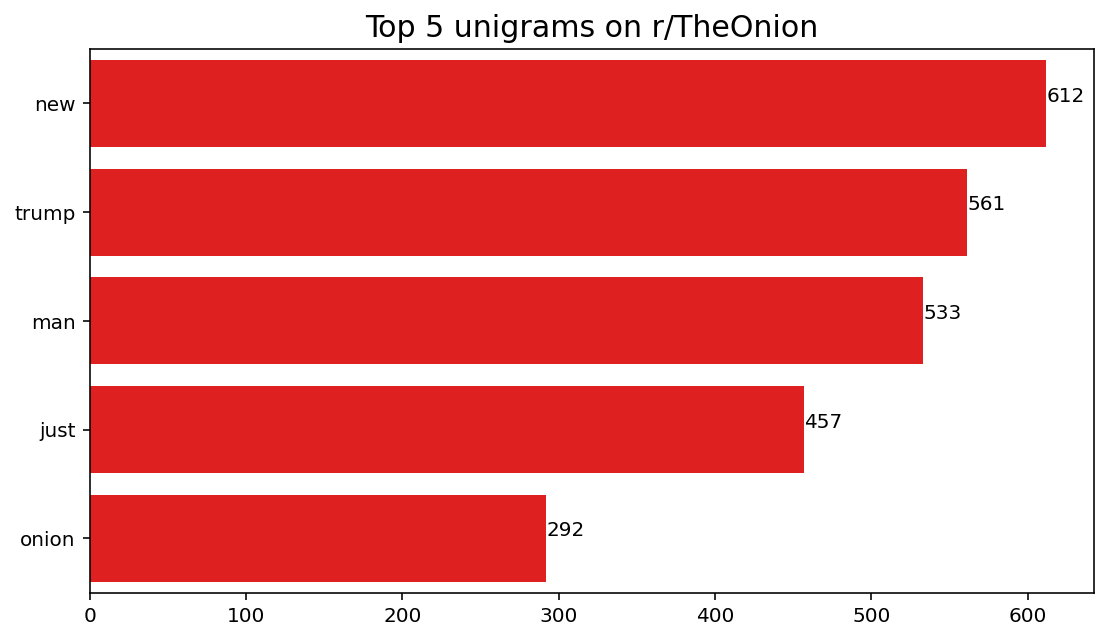

In [30]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Unigrams

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


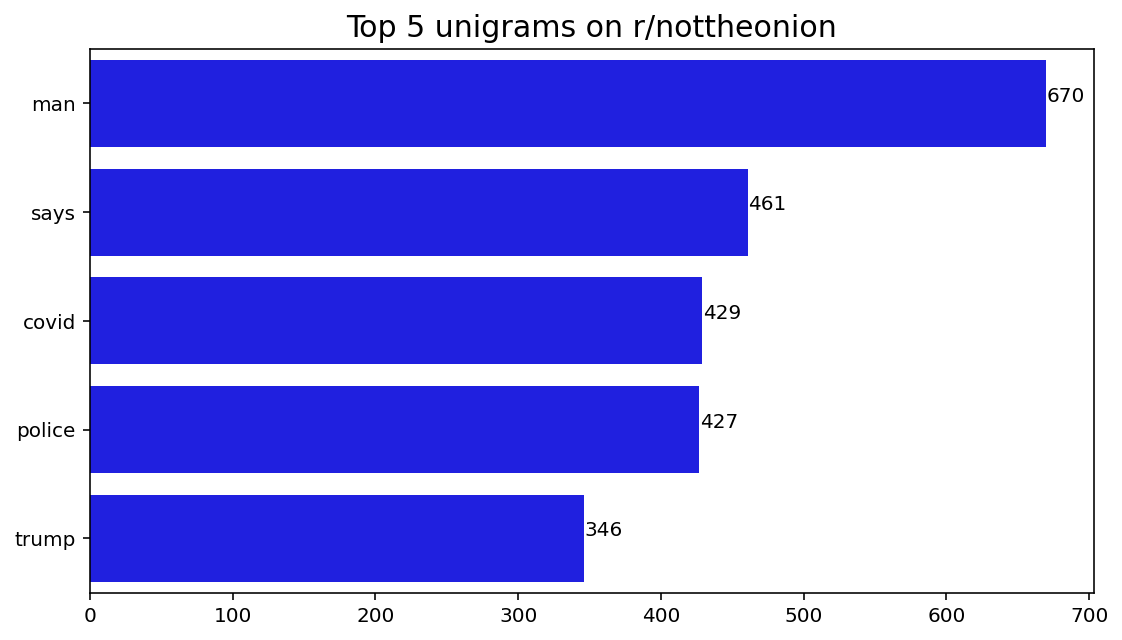

In [31]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b') 

### Common Unigrams between Top 5 in r/TheOnion & r/nottheonion

In [32]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (2,2)`

In [33]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(9043, 57563)


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (2,2)`

In [34]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(7977, 44843)


### r/TheOnion: Top 5 Bigrams

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


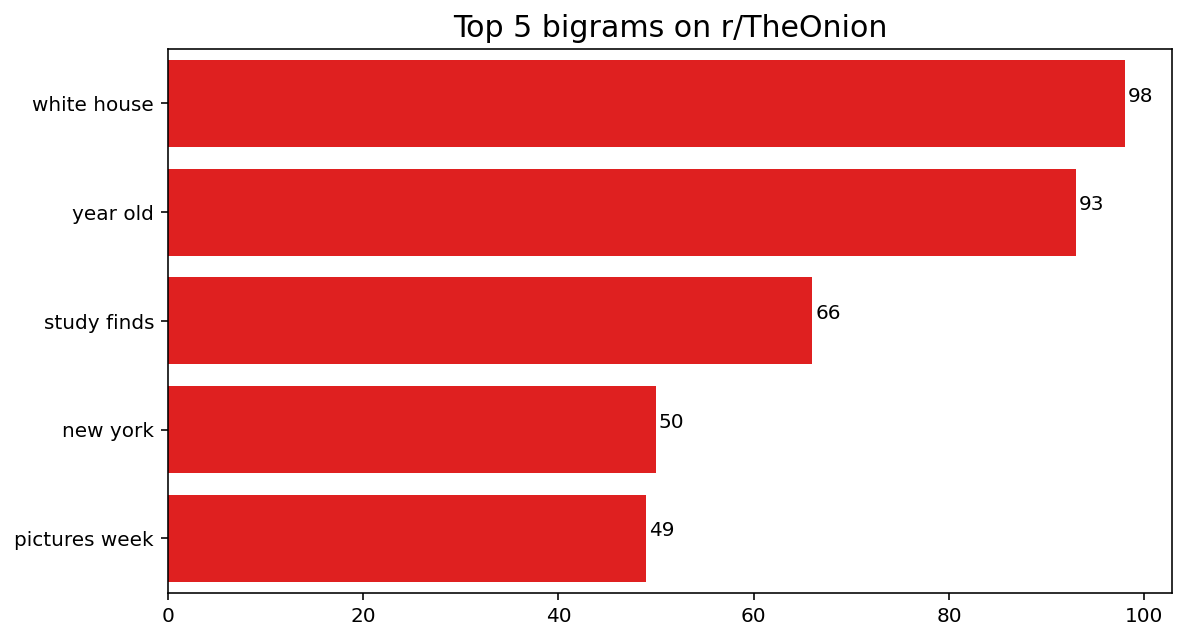

In [35]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Bigrams

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


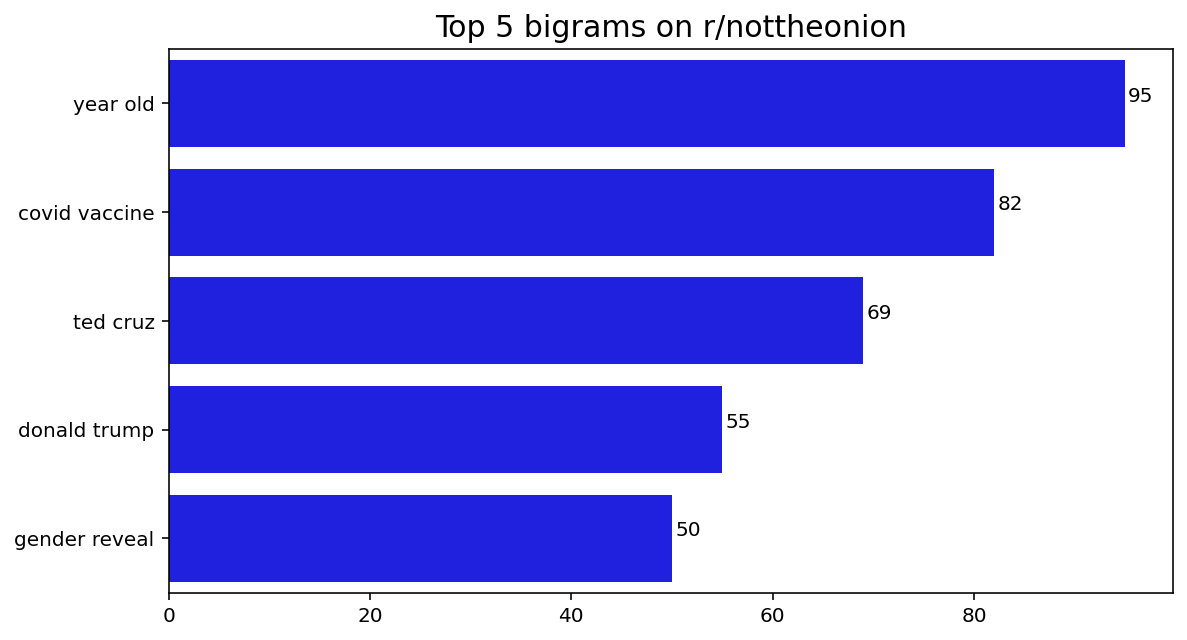

In [36]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b') 

### Common Bigrams between Top 5 in r/TheOnion & r/nottheonion

In [37]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

{'year old'}

Take out `{'man', 'new', 'just', 'police', 'says', 'trump', 'covid', 'onion'}` from dataset when modeling, since these words occur frequently in both subreddits. 

### Create custom `stop_words` to include common frequent words

Referencing the common most-used words, add them to a customized `stop_words` list. 

In [38]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

# Modeling

Here I conduct model-prep and use Pipeline and GridSearch to determine the most optimal model to run my data on. 

### Baseline Score

In [40]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.531316
0    0.468684
Name: subreddit, dtype: float64

I expect my model to be better than 54%. The majority class is `1`, or, `TheOnion`. If the model is not better than 54%, I know the model is not performing well.

### Set `X` (predictor) and `y` (target) variables 

In [41]:
X = df['title']
y = df['subreddit']

### Train/Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)

In [43]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8166079122600861
Train score 0.9983548766157462
Test score 0.8307873090481787


{'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'lr__C': 1}

Throughout my model testing, none of the stop_word lists were chosen as a best parameter. So from here on out, I omit them from my parameter selection. Additionally, while the model is overfitting, I am optimizing to get the highest accuracy score in my test set. 

### Model 2: TfidfVectorize & Logistic Regression

In [44]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8144927536231884
Train score 0.9233059146102625
Test score 0.8155111633372503


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 2)}

Model 1 performed with a better test score when comparing Logistic Regression models. 

### Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)

In [45]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8301605953779867
Train score 0.9958480219349785
Test score 0.83689776733255


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

The model is overfitting, but as I mentioned, I am optimizing for accuracy. I want to ensure that all predictions are correct. That is, all posts from r/TheOnion must be classified as being from the subreddit r/TheOnion, and all posts from r/nottheonion must be classified as being from the subreddit r/nottheonion. This model gives the best testing score.

### Model 4: TfidfVectorizer & MultinomialNB 

In [46]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8100274187230708
Train score 0.8856247551899726
Test score 0.8028202115158637


{'nb__alpha': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 3)}

When comparing test scores of my MultinomialNB models, Model 3 performs better.

# Best Models 

In this section, I take my two optimal models and run them. The first model, CountVectorizer & MultinomialNB, will be used to convey a confusion matrix which will show all evaluation scores. The second model, CountVectorizer & Logistic Regression, will be used to interpret my coefficients.

### CountVectorizer & MultinomialNB: Best Score

In [47]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.836427732079906


### Confusion Matrix

In [48]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[1607,  387],
       [ 309, 1952]])

Text(0.5, 257.44, 'Predicted label')

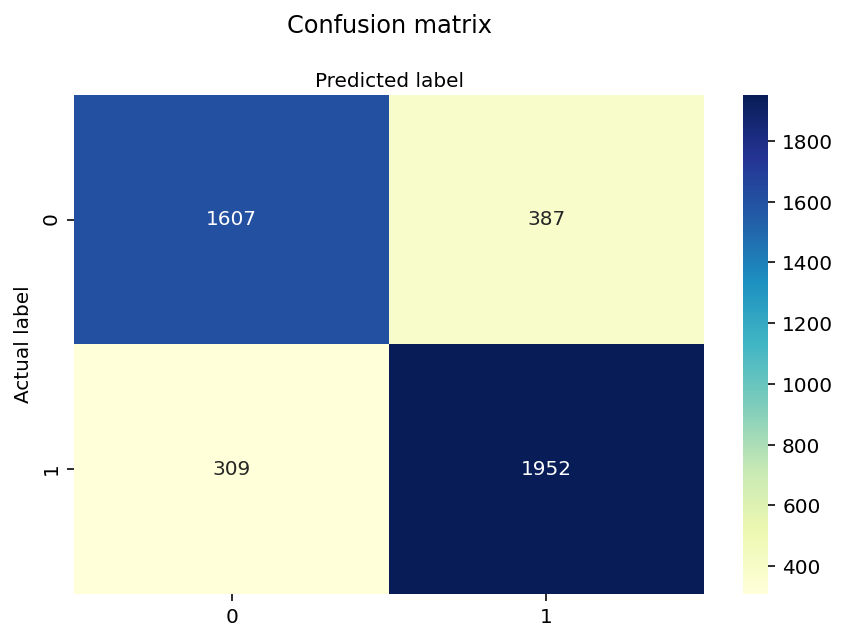

In [49]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [51]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 83.64 %
Precision: 83.45 %
Recall: 86.33 %
Specificity: 80.59 %
Misclassification Rate: 17.8 %


### CountVectorizer & Logistic Regression: Best Coefficient Interpretability

In [52]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [53]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8110458284371328


### Coefficient Analysis

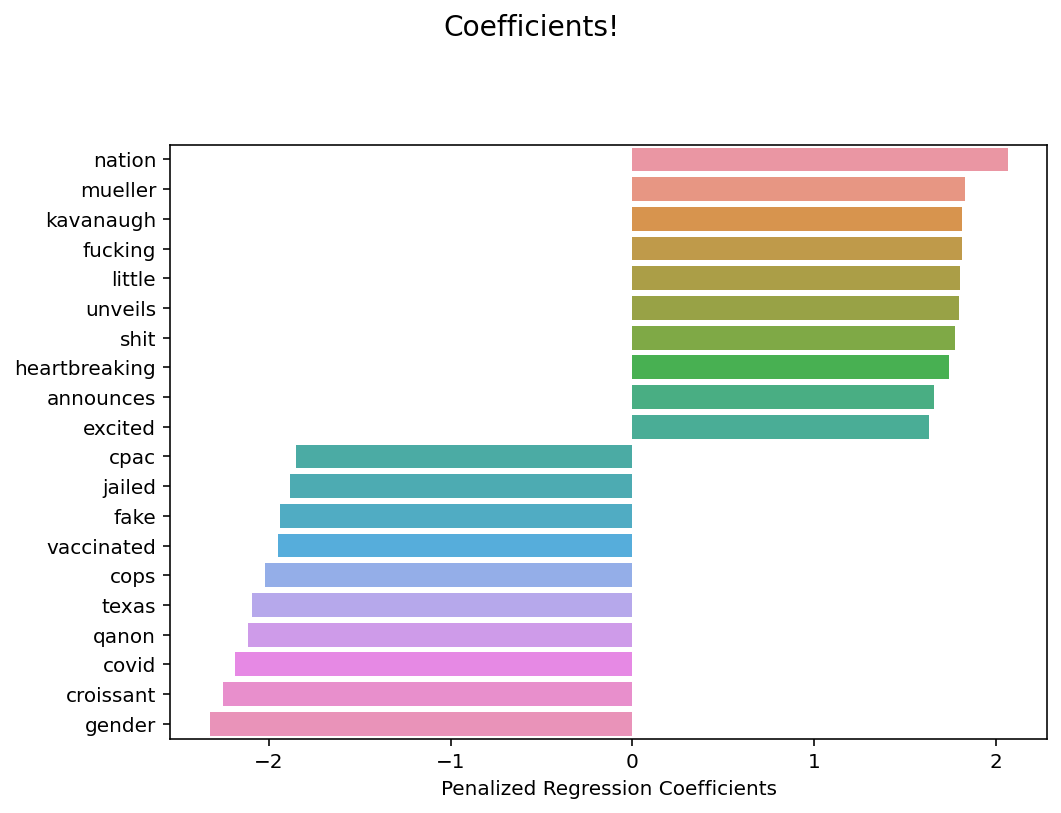

In [54]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)


# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [55]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is nation followed by mueller and kavanaugh .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is gender followed by croissant and covid .


In [56]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
nation,2.062,7.861677
mueller,1.829,6.227656
kavanaugh,1.813,6.128806
fucking,1.810,6.110447
little,1.798,6.037560
unveils,1.795,6.019475
shit,1.772,5.882607
heartbreaking,1.742,5.708750
announces,1.656,5.238316
excited,1.631,5.108981


In [57]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of nation increase by 1 in a title, that title is 7.86 times as likely to be classified as r/TheOnion.


In [58]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
gender,-2.322,10.196046
croissant,-2.248,9.468779
covid,-2.184,8.881762
qanon,-2.115,8.289586
texas,-2.093,8.109206
cops,-2.018,7.523263
vaccinated,-1.946,7.000629
fake,-1.939,6.951796
jailed,-1.880,6.553505
cpac,-1.852,6.372552


In [59]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of gender increase by 1 in a title, that title is 10.2 times as likely to be classified as r/nottheonion.


# Conclusions and Next-Steps

The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialDB. The optimal parameters for this model are where `ngram_range` = (1,3) and `alpha` = 0.36. 
 - Accuracy: 83.64%
 - Precision: 83.45%
 - Recall: 86.33%
 - Specificity: 80.59%
 - Misclassification Rate: 17.8%

To interpret my coefficients, I used my CountVectorizer & Logistic Regression model. 
 - The word that contributes the most positively to being from r/TheOnion is ' nation' followed by 'heartbreaking' and 'unarmed'.
   - As occurences of "nation" increase by 1 in a title, that title is 7.861 times as likely to be classified as r/TheOnion.

- The word that contributes the most positively to being from r/nottheonion is 'covid' followed by 'gender' and 'croissant '.  
  - As occurences of "gender" increase by 1 in a title, that title is 10.196 times as likely to be classified as r/nottheonion.

Natural Language Processing of text is one way to analyze fake news, but a major gap exists: image & video analysis. For my next-steps, I am interested in being able to interpret media (images and videos) and classify them as authentic news, fake news, or none of the above (i.e., media for entertainment).